### List of tables: 

1. [Table S2: Quality-quantity trade-off, clarification treatments only](#ols_quantity_quality)
2. [Table S3: Quality-quantity trade-off, clarification vs. no clarification](#ols_quantity_quality_extra_combined)
3. [Table S4: Estimating treatment effects on quantity, combined](#quantity)
4. [Table S5: Estimating treatment effects on quality, combined](#quality)

### List of figures:

1. [Figure S1: Time spent on intervention screen](#timer)
2. [Figure 5: Scatterplot quality vs. quantity, clarification traetments only](#scatter_quantity_quality)


In [1]:
%matplotlib inline

#### Imports libraries

In [2]:
import matplotlib.pyplot as plt #plotting
import numpy as np #matrix algebra
import os #file system
import pandas as pd #dataframe handling
import sys
import re # regular expression
import statsmodels.formula.api as smf # regressions
import statsmodels.api as sm #statisitcal analysis


from linearmodels.panel import RandomEffects #panel analysis 
from matplotlib.ticker import FuncFormatter #formating graphs 
from scipy import stats #stats module
from statsmodels.iolib.summary2 import summary_col #regression table
from statsmodels.stats.anova import anova_lm #regression anova

#### Turn off pandas' future warnings

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Import  tools

In [4]:
sys.path.insert(0, '../')
from tools import MyPanelModelComparison #edited for panel regression output

#### Set project directory

In [5]:
PROJECT_FOLDER = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
FINAL_DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data', 'final')
TABLES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'tables')
FIGURES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'figures')

#### Set display format

In [6]:
pd.options.display.float_format = '{:.2f}'.format

#### Set plotting style

In [7]:
plt.style.use('classic')

#### Set plotting properties 

In [8]:
bar_kwargs = dict(kind='bar', color='0.4', alpha=0.8, lw=0.5, width=0.7)
line_kwargs = dict(kind='line', lw=1, alpha=1, legend=True)
tick_kwargs = dict(size=5, which='both', right=False, top=False, direction='out', labelbottom=True)
font_kwargs = dict(fontsize=11, color='k')
grid_kwargs = dict(linewidth=1, axis="y", zorder=2, antialiased=True)
xlabel_kwargs = dict(fontsize=11, labelpad=3)
ylabel_kwargs = dict(fontsize=11, labelpad=3)
e_kwargs = dict(elinewidth=2, ecolor='0.15')
legend_kwargs = dict(frameon=False)

#### Retrieving dataframe

In [9]:
DATA = os.path.join(FINAL_DATA_FOLDER, 'benefit_data.feather')
df = pd.read_feather(DATA)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3094 entries, 0 to 3093
Columns: 441 entries, age to question80_timer
dtypes: float64(223), int64(25), object(193)
memory usage: 10.4+ MB


#### Sort dataframe by treatment 

In [10]:
df = df.sort_values('treatment')

#### Drop subjects for which the timer worked and did not work (10 min +/- 5%)

In [11]:
broken_timer = (df.duration_work < 600 * 0.95)|(df.duration_work > 600 * 1.05)
df = df[~broken_timer]

#### Figure S1: Time spent on intervention screen <a id='timer'></a>

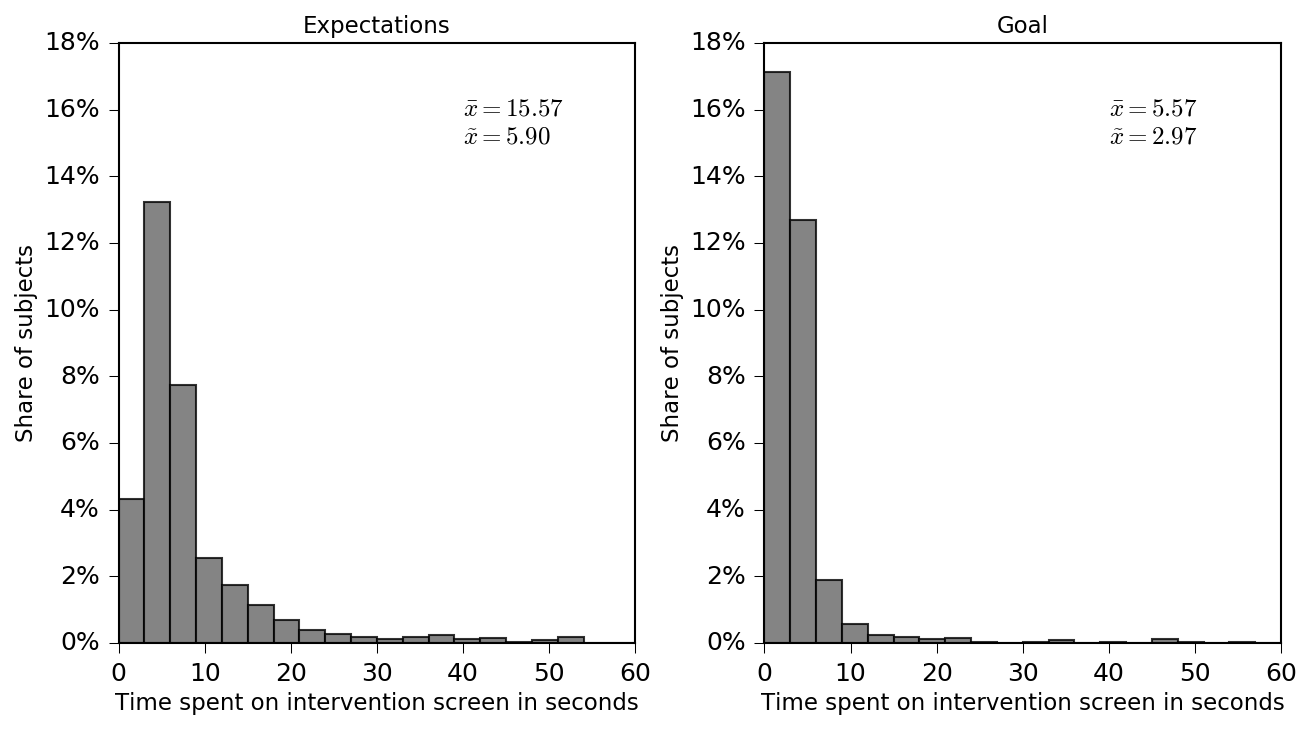

In [12]:
sel = (df.dataset != 6)
treat = df.treatment_second.unique()[-2:]

hist_params = dict(bins=20, range=(0, 60), density=True, color='0.4', alpha=0.8) 
fig, axis = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10, 5), dpi=150)
fig.subplots_adjust(hspace=0.35, wspace=0.25)
fig.set_facecolor('w')
for i, ax in enumerate(fig.axes):
    df_timer = df[(sel) & (df.treatment_second == treat[i])]['intervention_timer']
    df_timer.hist(ax=ax, **hist_params)
    ax.set_title(treat[i], **font_kwargs)
    ax.grid(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis='x', **tick_kwargs)
    ax.tick_params(axis='y', **tick_kwargs)
    ax.set_xlabel("Time spent on intervention screen in seconds", **xlabel_kwargs)
    ax.set_ylabel("Share of subjects", **ylabel_kwargs)
    ax.yaxis.set_major_formatter(FuncFormatter('{:.0%}'.format))
    mean, med = df_timer.mean(), df_timer.median() 
    ax.text(40, 0.15 , "${x}={a:.2f}$\n${b}={c:.2f}$".format(x=r"\bar{x}", a=mean, b=r"\~{x}", c=med)) 
plt.savefig(os.path.join(FIGURES_FOLDER, 'intervention_timer_hist.pdf'), bbox_inches='tight')

#### Select treatments for robsutness check 

In [13]:
treatment_list = [3, 4, 6, 7, 9, 10, 11, 12]
sel = df.treatment.isin(treatment_list)
df = df[sel]

#### Table S4: Estimating treatment effects on quantity <a id='quantity'></a>

In [14]:
regs = dict()
regs['reg1'] = 'counter_real ~ high_piece_rate'
regs['reg2'] = 'counter_real ~ expectations'
regs['reg3'] = 'counter_real ~ clarification'
regs['reg4'] = 'counter_real ~ high_piece_rate * expectations * clarification'
regs['reg5'] = regs['reg4'] + ' + age + female + education + mobile_device + latin'

ols_results = []
for k, v in regs.items():
    ols = smf.ols(formula=v, data=df).fit()
    ols = ols.get_robustcov_results()
    ols_results.append(ols)
    
order = [
    'high_piece_rate', 'expectations', 'clarification',
    'high_piece_rate:expectations', 'high_piece_rate:clarification', 'expectations:clarification',
    'high_piece_rate:expectations:clarification',
    'age', 'female', 'education', 'latin', 'mobile_device',
    'Intercept',
] 

auxiliary = {'N ': lambda x: "{:d}".format(int(x.nobs)), 'R2': lambda x: "{:.3f}".format(x.rsquared)}
ols_quan = summary_col(ols_results, stars=True, info_dict=auxiliary, float_format='%.3f', regressor_order=order)
ols_quan = ols_quan\
    .tables[0]\
    .rename(mapper=lambda x: x.replace('_', ' ').replace(':', ' * ').capitalize(), axis=0)\
    .rename(mapper=lambda x: x.capitalize().split()[0].replace('_', ' '), axis=1)\

ols_quan.to_latex(os.path.join(TABLES_FOLDER, 'ols_quantity_extra.tex'), bold_rows=True, float_format="%.3f")
display(ols_quan)

,Counter real,Counter real,Counter real,Counter real,Counter real
High piece rate,0.094,,,0.240,0.005
,(0.479),,,(0.801),(0.770)
Expectations,,-0.863*,,-1.347*,-1.758**
,,(0.479),,(0.799),(0.767)
Clarification,,,0.269,-0.543,-0.712
,,,(0.564),(1.068),(1.032)
High piece rate * expectations,,,,0.119,0.550
,,,,(1.095),(1.062)
High piece rate * clarification,,,,-0.087,0.469
,,,,(1.600),(1.528)


In [15]:
anova_lm(*ols_results, robust='hc3')

/home/sebastian/.virtualenvs/hidden_benefit_publication/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/sebastian/.virtualenvs/hidden_benefit_publication/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/sebastian/.virtualenvs/hidden_benefit_publication/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1589.00,144968.30,0.00,nan,nan,nan
1,1589.00,144675.28,-0.00,293.02,-inf,nan
2,1589.00,144950.23,-0.00,-274.95,inf,nan
3,1583.00,144327.39,6.00,622.84,1.22,0.29
4,1578.00,134344.89,5.00,9982.50,23.45,0.00


#### Transform dataframe to panel

In [16]:
columns_to_keep = df.columns[[0, 10, 12, 18, 19, 32, 33, 34, 36, 38, 39, 40]]
columns_to_melt = ['question{0}_editratio'.format(x) for x in range(1, df.counter.max() + 1)]

df_melted = pd.melt(
    df, 
    id_vars=columns_to_keep,
    value_vars = columns_to_melt,
    var_name='question_number',
    value_name='edit_ratio'
)

df_melted = df_melted.dropna(axis=0, how='any', subset=['edit_ratio'])
df_melted['question_number'] = df_melted['question_number'].str.extract(r'(\d+)').astype(int)
df_melted['edit_ratio'] = df_melted['edit_ratio'].astype(float)

df_panel = df_melted.set_index(['workerid', 'question_number'])
df_panel = df_panel.sort_index()
df_panel.head(20) 

age  education  female  latin  mobile_device  \
workerid question_number                                                  
200      1               47.00          5       0      2              0   
         2               47.00          5       0      2              0   
         3               47.00          5       0      2              0   
         4               47.00          5       0      2              0   
         5               47.00          5       0      2              0   
         6               47.00          5       0      2              0   
         7               47.00          5       0      2              0   
         8               47.00          5       0      2              0   
         9               47.00          5       0      2              0   
         10              47.00          5       0      2              0   
         11              47.00          5       0      2              0   
         12              47.00          5       0      2              0   
         13              47.00          5       0      2              0   
         14              47.00          5       0      2              0   
         15              47.00          5       0      2              0   
         16              47.00          5       0      2              0   
         17              47.00          5       0      2              0   
         18              47.00          5       0      2              0   
201      1               31.00          1       1      1              0   
         2               31.00          1       1      1              0   

                          high_piece_rate  low_piece_rate  expectations  \
workerid question_number                                                  
200      1                              0               1             0   
         2                              0               1             0   
         3                              0               1             0   
         4                              0               1             0   
         5                              0               1             0   
         6                              0               1             0   
         7                              0               1             0   
         8                              0               1             0   
         9                              0               1             0   
         10                             0               1             0   
         11                             0               1             0   
         12                             0               1             0   
         13                             0               1             0   
         14                             0               1             0   
         15                             0               1             0   
         16                             0               1             0   
         17                             0               1             0   
         18                             0               1             0   
201      1                              0               1             1   
         2                              0               1             1   

                          neutral  clarification  no_clarification  edit_ratio  
workerid question_number                                                        
200      1                      1              0                 1        0.00  
         2                      1              0                 1        0.00  
         3                      1              0                 1        0.00  
         4                      1              0                 1        0.00  
         5                      1              0                 1        0.00  
         6                      1              0                 1        0.00  
         7                      1              0                 1        0.0

#### Table S5: Estimating treatment effects on quality  <a id='quality'></a>

In [17]:
regs = dict()
regs['re1'] = 'edit_ratio ~ 1 + high_piece_rate'
regs['re2'] = 'edit_ratio ~ 1 + expectations'
regs['re3'] = 'edit_ratio ~ 1 + clarification'
regs['re4'] = 'edit_ratio ~ 1 + high_piece_rate * expectations * clarification'
regs['re5'] = regs['re4'] + ' + age + female + education + mobile_device + latin'

re_results = []
for k, v in regs.items():
    re_result = RandomEffects.from_formula(formula=v, data=df_panel).fit(cov_type='robust')
    re_results.append(re_result)
re_qual = MyPanelModelComparison(re_results)

path = os.path.join(TABLES_FOLDER, 're_extra_quality.tex')
with open(path, "w") as latex:
    latex.write(re_qual.summary.as_latex())

display(re_qual)

,Model 0,Model 1,Model 2,Model 3,Model 4
Dep. Variable,edit_ratio,edit_ratio,edit_ratio,edit_ratio,edit_ratio
Estimator,RandomEffects,RandomEffects,RandomEffects,RandomEffects,RandomEffects
No. Observations,37818,37818,37818,37818,37818
Cov. Est.,Robust,Robust,Robust,Robust,Robust
R-squared,0.0016,0.0016,0.0016,0.0018,0.0021
R-Squared (Within),0.0000,0.0000,0.0000,0.0000,0.0000
R-Squared (Between),0.0002,9.81e-05,0.0003,0.0054,0.0132
R-Squared (Overall),-0.0025,-0.0028,-0.0027,-0.0042,-0.0022
F-statistic,59.086,58.958,59.190,9.4896,6.5549
P-value (F-stat),0.0000,0.0000,0.0000,0.0000,0.0000


#### Calculate average error rate and append to cross sectional dataframe

In [18]:
avg_edit_ratio = df_panel['edit_ratio'].mean(level=0).to_frame(name='avg_edit_ratio')
df = df.merge(avg_edit_ratio, left_on='workerid', right_on='workerid', validate='one_to_one')

#### Figure 2: Scatterplot quality vs. quantity, clarification traetments only <a id='scatter_quantity_quality'></a>

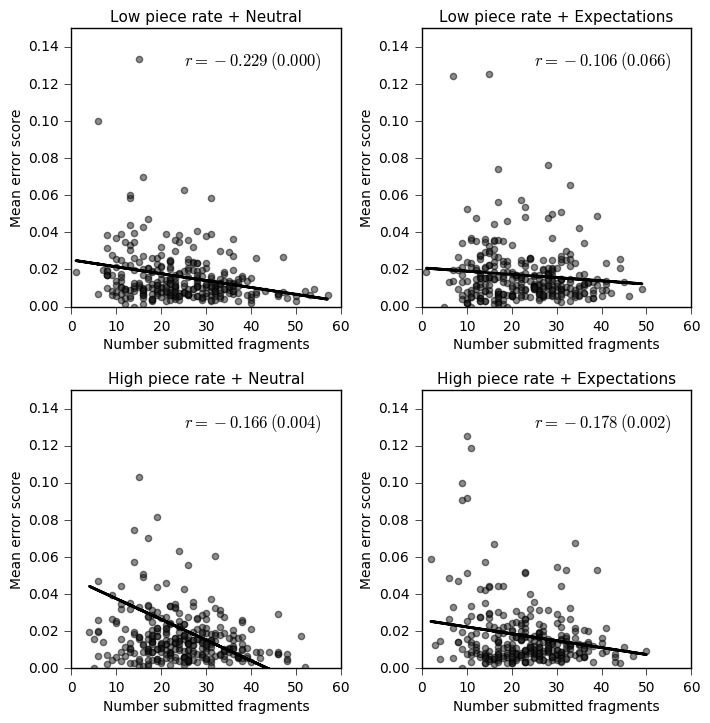

In [19]:
def get_fitted_values(df, x, y):
    y = df.loc[:,y]
    x = df.loc[:,x]
    x = sm.add_constant(x)
    ols = sm.OLS(y, x).fit()
    return ols.fittedvalues

index = pd.Index([
    'Low piece rate + Neutral + Clarification',
    'Low piece rate + Expectations + Clarification',
    'High piece rate + Neutral + Clarification',
    'High piece rate + Expectations + Clarification',
    ], dtype='object', name='Treatment')

x_var, y_var = 'counter_real', 'avg_edit_ratio'
scatter_params = dict(xlim=[0, 60], ylim=[0, 0.15], color='0.1', alpha=0.5)
with plt.style.context('classic'):
    fig, axis = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), dpi=100)
    fig.set_facecolor('w')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(fig.axes):
        treatment = df.treatment_str.unique()[i]
        df_scatter = df[(df.treatment_str == treatment)]
        df_scatter.plot.scatter(x=x_var, y=y_var, ax=ax, **scatter_params)
        ax.plot(df_scatter[x_var], get_fitted_values(df_scatter, x_var, y_var), c='0', lw=2)
        r, p = stats.pearsonr(df_scatter[x_var], df_scatter[y_var])
        ax.text(25, 0.13 , r"$r={a:.3f}\:({b:.3f})$".format(a=r, b=p))
        ax.set_title(treatment.replace(' + Clarification', '\n + Clarification'), **font_kwargs)
        ax.tick_params(axis='x', labelsize='small', **tick_kwargs)
        ax.tick_params(axis='y', labelsize='small', **tick_kwargs)
        ax.set_xlabel("Number submitted fragments", fontsize='small', labelpad=3)
        ax.set_ylabel("Mean error score", fontsize='small', labelpad=3)
plt.savefig(os.path.join(FIGURES_FOLDER, 'corr_counter_real_extra_editratio.pdf'))

#### Table S2: Quality-quantity trade-off, clarification treatments only  <a id='ols_quantity_quality'></a>

In [20]:
regs = dict()
regs['re0'] = 'avg_edit_ratio ~ counter_real'
regs['re1'] = 'avg_edit_ratio ~ counter_real + C(treatment_str)'
regs['re2'] = 'avg_edit_ratio ~ counter_real + counter_real:C(treatment_str)'
regs['re3'] = 'avg_edit_ratio ~ counter_real * C(treatment_str)'

ols_results = []
for k, v in regs.items():
    ols = smf.ols(formula=v, data=df[df.treatment.isin([9,10,11,12])]).fit()
    ols = ols.get_robustcov_results()
    ols_results.append(ols)

order = ['Intercept', 'counter_real'] 
auxiliary = {'N': lambda x: "{:d}".format(int(x.nobs)), 'R2': lambda x: "{:.3f}".format(x.rsquared)}
ols_qual_quan = summary_col(ols_results, stars=True, info_dict=auxiliary, float_format='%.4f', regressor_order=order)
ols_qual_quan = ols_qual_quan\
    .tables[0]\
    .rename(mapper=lambda x: x.replace('C(treatment_str)[T.', '').replace(']', ''), axis=0)\
    .rename(mapper=lambda x: x.capitalize().split()[0].replace('_',' '), axis=1)\
    .rename({'Intercept':'Constant'})

ols_qual_quan.to_latex(os.path.join(TABLES_FOLDER, 'ols_quality_quanity_extra.tex'), bold_rows=True, float_format="%.3f")
display(ols_qual_quan)

,Avg edit ratio,Avg edit ratio,Avg edit ratio,Avg edit ratio
Constant,0.0344***,0.0302***,0.0348***,0.0182***
,(0.0125),(0.0108),(0.0127),(0.0053)
counter_real,-0.0006,-0.0006,-0.0007,-0.0001
,(0.0004),(0.0005),(0.0005),(0.0002)
High piece rate + Neutral + Clarification,,0.0045*,,0.0006
,,(0.0027),,(0.0069)
Low piece rate + Expectations + Clarification,,0.0116,,0.0527
,,(0.0089),,(0.0448)
Low piece rate + Neutral + Clarification,,0.0027,,0.0089
,,(0.0020),,(0.0069)


#### Table S3: Quality-quantity trade-off, clarification vs. no clarification <a id='ols_quantity_quality_extra_combined'></a>

In [21]:
regs = dict()
regs['re0'] = 'avg_edit_ratio ~ counter_real'
regs['re1'] = 'avg_edit_ratio ~ counter_real * clarification'
regs['re2'] = regs['re1'] + ' + age + female + education + mobile_device + latin'

ols_results = []
for k, v in regs.items():
    ols = smf.ols(formula=v, data=df).fit()
    ols = ols.get_robustcov_results()
    ols_results.append(ols)

order = ['counter_real', 'clarification', 'counter_real:clarification',
         'age', 'female' , 'education', 'mobile_device', 'latin', 'Intercept'] 
auxiliary = {'N': lambda x: "{:d}".format(int(x.nobs)), 'R2': lambda x: "{:.3f}".format(x.rsquared)}
ols_qual_quan = summary_col(ols_results, stars=True, info_dict=auxiliary, float_format='%.4f', regressor_order=order)
ols_qual_quan.add_title('Regression table: Quality vs. Quantiy OLS')
ols_qual_quan = ols_qual_quan\
    .tables[0]\
    .rename(mapper=lambda x: x.replace('C(treatment_str)[T.', '').replace(']', '').capitalize(), axis=0)\
    .rename(mapper=lambda x: x.capitalize().split()[0].replace('_',' '), axis=1)\
    .rename({'Intercept':'Constant'})

ols_qual_quan.to_latex(os.path.join(TABLES_FOLDER, 'ols_quality_quanity_extra_combined.tex'), bold_rows=True, float_format="%.3f")
display(ols_qual_quan)

,Avg edit ratio,Avg edit ratio,Avg edit ratio
Counter_real,-0.0005***,-0.0005***,-0.0005***
,(0.0002),(0.0001),(0.0001)
Clarification,,0.0047,0.0041
,,(0.0132),(0.0132)
Counter_real:clarification,,-0.0001,-0.0001
,,(0.0005),(0.0005)
Age,,,-0.0001
,,,(0.0001)
Female,,,-0.0051***
,,,(0.0017)


#### Calculate sample correlation coefficient with and without clarification statement 

In [22]:
for value in df.treatment_third.unique():
    x = df[df.treatment_third == value]['counter_real']
    y = df[df.treatment_third == value]['avg_edit_ratio']
    print('{0}: r={1[0]:.3f}, p={1[1]:.3f}, n={2}'.format(value, stats.pearsonr(x, y), x.count())) 

No Clarification: r=-0.135, p=0.000, n=1195
Clarification: r=-0.137, p=0.006, n=396


#### Test difference in sample pcc with and without clarification statement 

In [23]:
def test_diff_r(r1, r2, n1, n2):
    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)
    sd = np.sqrt((1 / (n1 - 3)) + (1 / (n2 - 3)))
    z = np.abs(z1 - z2) / sd
    p_one = stats.norm.sf(z)
    p_two = 2 * p_one
    return z, p_one, p_two 

result = test_diff_r(0.135, 0.137, 1195, 396)
print("z-score={0[0]:.3f}, p={0[1]:.3f} (one-tailed), p={0[2]:.3f} (two-tailed)".format(result)) 

z-score=0.035, p=0.486 (one-tailed), p=0.972 (two-tailed)
